In [1]:
import re
# Reads and closes file before returning the content as a string
def read_file(fileName):
    file = open(fileName)
    fileContent = file.read()
    file.close()
    return fileContent

# Separates the inputted content into 4 lists of metrics (4 since we know that these metrics are always outputted)
def separate_metrics(fileString, ping_data = [], rss_data = [], route_data = [], link_data = []):
    fileString = remove_separations(fileString)

    # Split into lists of data
    for index, content in enumerate(fileString):
        if(index % 4 == 0):
            ping_data.append(content) 
        elif(index % 4 == 1):
            rss_data.append(content)
        elif(index % 4 == 2):
            route_data.append(content)
        elif(index % 4 == 3):
            link_data.append(content)

    return ping_data, rss_data, route_data, link_data

# Removes the redundant separations that are purely for visual assistance
def remove_separations(fileString):
    fileString = remove_occurrences(fileString, "----------------------------------------------------------------")
    fileString = remove_occurrences(fileString, "____________________________START_______________________________")
    fileString = remove_occurrences(fileString, "___________________________END__________________________________")
    fileString = remove_occurrences(fileString, "")
    return fileString

# Removes all occurences of a given item in a string
def remove_occurrences(fileString, item):
    res = [i for i in fileString if i != item]
    return res

# Extract packet loss, average rtt and the standard deviation of the rtt from the list of ping data
def read_ping_data(ping_data, packet_loss_list = [], avg_rtt_list = [], std_deviation_rtt = []):
    for entry in ping_data:
        ping_information = entry.split("---")[2]
        split_information = ping_information.split(",")
        packet_loss_list.append(split_information[2].split("%")[0])
        avg_rtt_list.append(split_information[3].split("/")[4])
        std_deviation_rtt.append(split_information[3].split("/")[6][:-3])

    return packet_loss_list, avg_rtt_list, std_deviation_rtt

# Extract RSS and average RSS from the list of RSS data
def read_rss_data(rss_data, rss_list = [], rss_avg_list = []):
    for entry in rss_data:
        rss_list.append(find_between(entry, "signal: ", "["))
        rss_avg_list.append(find_between(entry, "signal avg: ", "["))

    return rss_list, rss_avg_list

# Finds and returns the string between two given sequences of strings
def find_between(s, first, last, minusIndex = 0):
    start = s.index(first)+len(first)
    end = s.index(last, start)+minusIndex
    return s[start:end]

# Turns a list of strings into a list of floats
def list_string_to_float(stringList):
    floatList = [float(x) for x in stringList]
    return floatList

# Turns a list of strings into a list of floats
def list_string_to_int(stringList):
    intList = [int(x) for x in stringList]
    return intList

# Returns the average of a list
def list_average(list):
    return (sum(list) / len(list))


def split_iperf(iperfString):
    iperf_output_list = []
    iperf_output_list_initial = iperfString.split("iperf Done.")
    iperf_output_list_initial.pop()
    for entry in iperf_output_list_initial:
        server_client_list = entry.split("Server output:")
        server_client_edited_list = []
        str_to_find = "- - - - - - - - - - - - - - - - - - - - - - - - -"
        for s_c_entry in server_client_list:
            s_c_entry = s_c_entry[s_c_entry.find(str_to_find)+len(str_to_find)+1:]
            server_client_edited_list.append(s_c_entry)
        iperf_output_list.append(server_client_edited_list)

    return iperf_output_list

def append_to_list(value, list, unit):
    if(unit == 'M' or unit == 'm'):
        list.append(float(value)*1000*1000)
    elif(unit == 'K' or unit == 'k'):
        list.append(float(value)*1000)
    else:
        list.append(float(value))
    return
    
# Extracts iperf into a list of lists in the following format:
# Index 0 (Client): [Time Taken] [MBytes sent] [Bitrate] [Retries]
# Index 1 (Server): [Time Taken] [MBytes sent] [Bitrate] [NaN]
# Index 2 (Client): [Time Taken] [MBytes sent] [Bitrate] [Retries]
# ...
# Index n (Server): [Time Taken] [MBytes sent] [Bitrate] [NaN]
def extract_iperf(iperf_list):
    s_c_entry_list = []
    for s_c_entry in iperf_list:
        entry_list = []
        for entry in s_c_entry:
            entry_list = []
            time_taken = find_between(entry, "-", "sec").strip()
            entry_list.append(time_taken)
            
            bits_transferred = find_between(entry, "sec", "Bytes").strip()
            append_to_list(bits_transferred[:-1], entry_list, bits_transferred[-1])

            try:
                try:
                    transfer_rate = find_between(entry, "MBytes", "bits/sec").strip()
                    append_to_list(transfer_rate[:-1], entry_list, transfer_rate[-1])
                except:
                    transfer_rate = find_between(entry, "KBytes", "bits/sec").strip()
                    append_to_list(transfer_rate[:-1], entry_list, transfer_rate[-1])
            except:
                transfer_rate = find_between(entry, " Bytes", "bits/sec").strip()
                append_to_list(transfer_rate[:-1], entry_list, transfer_rate[-1])
            if "Retr" in entry:
                retry_number = find_between(entry, "/sec", "sender").strip()
                entry_list.append(retry_number)
            s_c_entry_list.append(entry_list)
    return s_c_entry_list



def read_station_dump(rss_data):
    mac_list = []
    signal_list = []
    rss_list = []
    rss_avg_list = []
    for entry in rss_data:
       mac_list.append(re.findall(r'(?:[0-9a-fA-F]:?){12}',entry, re.ASCII))
       signal_list.append(re.findall(r'\[[^\]]*]',entry))
    
    rss_list, rss_avg_list = zip(*signal_list)
    
    print(mac_list) 
    #print(signal_list)  
    return mac_list, rss_list, rss_avg_list

In [2]:
content = read_file("../Distance/Dongle/Single-hop_interference/results_10m.txt")
split_content = content.split("\n")
ping_data, rss_data, route_data, link_data = separate_metrics(split_content)
# packet_loss_list, avg_rtt_list, std_deviation_rtt = read_ping_data(ping_data)
#rss_list, rss_avg_list = read_rss_data(rss_data)
mac_list = read_station_dump(rss_data)
#iperfContent = read_file("../Dongle/iperf_results.txt")
#iperf_output_list = split_iperf(iperfContent)
#iperf_list = extract_iperf(iperf_output_list)
#hello = 1
# TODO: Still missing extraction of LINK and ROUTE metrics 
# I am not sure what is important in these measurements, so figure this out. In route the routing metric is probably important/interesting to look at
#
# Answer: Routing protocol metric might be interesting to look at. The stale metric from Link. And the p metric from route.


# TODO: How should we do the plotting of different experiments within one experiment? 
# Should we just average the measurements across the list of data measurements from each experiment and then plot these averages against each other?
#
# Answer: Attempt to use the full range of measurements across one experiment and then color code according to experiment.

[['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4'], ['e4:95:6e:4e:3d:a4']]


In [4]:
import matplotlib.pyplot as plt

# ######### Prepare lists by turning them into floats/ints instead of strings######
# # Int
# rss_list = list_string_to_int(rss_list)
# rss_avg_list = list_string_to_int(rss_avg_list)
iperf_sender_list = [column[1] for column in iperf_list]
iperf_receiver_list = [column[2] for column in iperf_list]
iperf_sender_bytes = list_string_to_float(iperf_sender_list)
iperf_receiver_bytes = list_string_to_float(iperf_receiver_list)

# # Float
# avg_rtt_list = list_string_to_float(avg_rtt_list)
# std_deviation_rtt = list_string_to_float(std_deviation_rtt)
# packet_loss_list = list_string_to_float(packet_loss_list)
# #################################################################################

# # Example of plotting
# x_axis = list(range(1, len(rss_avg_list)+1))
# fig_avg_rss, axis_avg_rss = plt.subplots()
# axis_avg_rss.plot(x_axis, rss_avg_list)
# axis_avg_rss.set_title("Average of RSS")
# axis_avg_rss.set_xlabel("Sample number")
# axis_avg_rss.set_ylabel("Average RSS value")
x_axis = list(range(1,len(iperf_sender_bytes)+1))
fig_iperf, axis_iperf = plt.subplots()
axis_iperf.plot(x_axis, iperf_sender_bytes)
axis_iperf.plot(x_axis, iperf_receiver_bytes)

NameError: name 'iperf_list' is not defined

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.markers import MarkerStyle # For making the Y-axis whole numbers

def scatter_plot_iperf_bitrate(path, y_label, x_label, x_axis_values, color_dictionary):
    
    distance_iperf_files = path

    iperf_sender_results_list = []
    iperf_receiver_results_list = []
    for file in distance_iperf_files:
        iperfContent = read_file(file)
        iperf_output_list = split_iperf(iperfContent)
        iperf_list = extract_iperf(iperf_output_list)
        iperf_sender_list, iperf_receiver_list = [], []
        for index, entry in enumerate(iperf_list):
            if(index % 2 == 0):
                iperf_sender_list.append(entry)
            else:
                iperf_receiver_list.append(entry)

        iperf_sender_bitrate = [column[2] for column in iperf_sender_list]
        iperf_receiver_bitrate = [column[2] for column in iperf_receiver_list]
        iperf_sender_results_list.append(iperf_sender_bitrate)
        iperf_receiver_results_list.append(iperf_receiver_bitrate)


    iperf_sender_results_list[6].append(0.0)
    x_axis = x_axis_values

    y_axis = []
    for entry in iperf_sender_results_list:
        y_axis = np.concatenate((y_axis, entry))


    color_dict = color_dictionary
            
    for x_value, y_value in zip(x_axis, y_axis):
        plt.scatter(x=x_value, y=y_value, marker='o', color=color_dict[x_value])
    plt.ylabel(y_label)
    plt.xlabel(x_label)

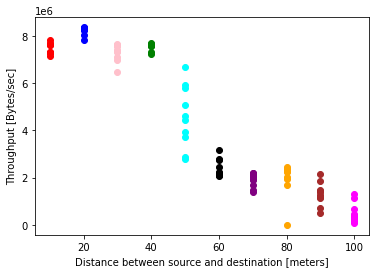

In [9]:
############# DISTANCE EXPERIMENT - Visualization of Bitrate  #####################
distance_file_iperf = "../Distance/Dongle/Single-hop/iperf_results_"
distance_iperf_files = [distance_file_iperf + "10m.txt",
                        distance_file_iperf + "20m.txt",
                        distance_file_iperf + "30m.txt",
                        distance_file_iperf + "40m.txt",
                        distance_file_iperf + "50m.txt",
                        distance_file_iperf + "60m.txt",
                        distance_file_iperf + "70m.txt",
                        distance_file_iperf + "80m.txt",
                        distance_file_iperf + "90m.txt",
                        distance_file_iperf + "100m.txt"
                        ]
y_label = "Throughput [Bytes/sec]"
x_label = "Distance between source and destination [meters]"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
            50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

color_dict = {
    10: 'red', 
    20: 'blue', 
    30: 'pink', 
    40: 'green', 
    50: 'cyan', 
    60: 'black', 
    70: 'purple', 
    80: 'orange', 
    90: 'brown',
    100: 'magenta'}

scatter_plot_iperf_bitrate(distance_iperf_files,y_label,x_label,x_axis,color_dict)

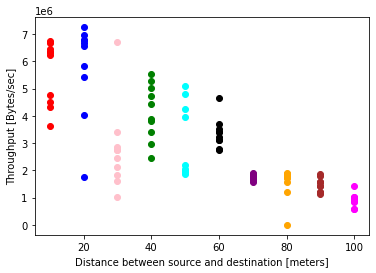

In [11]:
############# DISTANCE EXPERIMENT INTERFERENCE - Visualization of Bitrate  #####################
distance_file_iperf = "../Distance/Dongle/Single-hop_interference/iperf_results_"
distance_iperf_files = [distance_file_iperf + "10m.txt",
                        distance_file_iperf + "20m.txt",
                        distance_file_iperf + "30m.txt",
                        distance_file_iperf + "40m.txt",
                        distance_file_iperf + "50m.txt",
                        distance_file_iperf + "60m.txt",
                        distance_file_iperf + "70m.txt",
                        distance_file_iperf + "80m.txt",
                        distance_file_iperf + "90m.txt",
                        distance_file_iperf + "100m.txt"
                        ]

y_label = "Throughput [Bytes/sec]"
x_label = "Distance between source and destination [meters]"
x_axis = [  10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
            40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
            50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
            60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
            70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
            80, 80, 80, 80, 80, 80, 80, 80, 80, 80,
            90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
            100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

color_dict = {
    10: 'red', 
    20: 'blue', 
    30: 'pink', 
    40: 'green', 
    50: 'cyan', 
    60: 'black', 
    70: 'purple', 
    80: 'orange', 
    90: 'brown',
    100: 'magenta'}

scatter_plot_iperf_bitrate(distance_iperf_files,y_label,x_label,x_axis,color_dict)